In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [1]:
# activate line execution
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import os
import numpy as np

import pickle

In [3]:
add = "../../hkgan/data/synthetic_data.pkl"
with open(add, "rb") as f:
    data = pickle.load(f)

In [4]:
len(data)
data[0][-1]
data[0][0]

2048

{'Label': 0}

{'ts': array([ 12,  31,  47,  74,  91,  93, 109, 112, 120, 130, 131, 134, 135,
        145, 153, 171, 172, 199, 205, 206, 211, 218, 222, 223, 226, 232,
        236, 237, 238, 257, 272, 274, 283, 286, 289, 291, 306, 307, 309,
        327, 335, 370, 390, 401, 415, 421, 422, 427, 431, 439, 471, 478,
        485, 487, 522, 523, 524, 531, 541, 544, 545, 546, 547, 548, 560,
        593, 594, 598, 606, 609, 622, 637, 643, 667, 672, 693, 694, 695,
        707, 709, 737, 758, 760, 765, 791]),
 'y': array([ 0.27187548,  0.35895889,  0.08259013, -0.41126742, -0.20912402,
        -0.17816355,  0.22223521,  0.27517667,  0.38499074,  0.37717732,
         0.37573792,  0.33670126,  0.32935787,  0.1185938 , -0.08244946,
        -0.39481008, -0.39156102,  0.0052703 ,  0.108093  ,  0.16291101,
         0.25334775,  0.37631775,  0.39211726,  0.40812232,  0.3954142 ,
         0.34872976,  0.30937217,  0.29320348,  0.26919929, -0.16682025,
        -0.38707878, -0.40546029, -0.34776534, -0.3141696 , -0.24696

In [5]:
sta = pd.DataFrame(data=[x[-1] for x in data], columns=["Label"])
sta
sta.Label.sum()

,Label
0,0
1,0
2,0
3,0
4,0
...,...
2043,1
2044,1
2045,1
2046,1


1024

In [6]:
n_samples = len(data)
dyn = []
for i in range(n_samples):
    t1 = data[i][0]['ts']
    sig1 = data[i][0]['y']
    t2 = data[i][1]['ts']
    sig2 = data[i][1]['y']
    t= np.concatenate((t1,t2))
    sig = np.concatenate((sig1,sig2))
    name = np.concatenate((np.repeat('S1',len(t1)),np.repeat('S2',len(t2))))
    # t.shape, sig.shape, name.shape
    
    temp = pd.DataFrame(data={'time':t, 'value':sig,'name':name})
    # temp.head()
    temp = temp.pivot(index='time', columns='name', values='value').reset_index()
    temp.columns.name = None
    # temp.head()

    dyn.append(temp)


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00036621,
        0.00305176, 0.01220703, 0.02404785, 0.03027344, 0.0300293 ,
        0.01647949, 0.00720215, 0.00097656, 0.00036621, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
        264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
        352., 360., 36

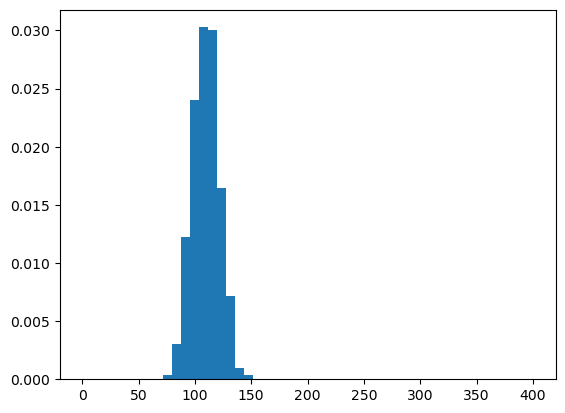

In [7]:
sta_types = ['binary',"int"]
dyn_types = ['continuous']*len(dyn[0].columns)
dynamics = pd.concat(dyn)
seq_len = [len(x) for x in dyn]
sta["seq_len"]=np.array(seq_len)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(seq_len, range=(0,400), bins=50, density=True)
plt.show()

In [8]:
from general.missingprocessor import Processor
d_P = Processor(dyn_types, use_pri='time')
s_P = Processor(sta_types)
d_P.fit(dynamics)
s_P.fit(sta)

all values are integer
time 1 None int None
[799.] [0.]
S1 1 0.25492644894245264 continuous None
[0.78452213] [-0.79296112]
S2 1 0.3814485410217754 continuous None
[0.78926947] [-0.79873162]
Label 1 None binary None
seq_len 1 None int None
[150.] [77.]


In [9]:
def build_dataset(sta, dyn, seq_len):
    s = s_P.transform(sta)
    d_lis=[d_P.transform(ds) for ds in dyn]
    d = [x[0].tolist() for x in d_lis]
    lag = [x[1].tolist() for x in d_lis]
    mask = [x[2].tolist() for x in d_lis]
    times = [x[-1].tolist() for x in d_lis]
    priv = [x[3].tolist() for x in d_lis]
    nex = [x[4].tolist() for x in d_lis]
    label = [float(x[-2]) for x in s] 
    from fastNLP import DataSet
    dataset = DataSet({"seq_len": seq_len, 
                       "dyn": d, "lag":lag, "mask": mask,
                       "sta": s, "times":times, "priv":priv, "nex":nex, "label": label
                      })
    return dataset

dataset = build_dataset(sta, dyn, seq_len)

In [10]:
test_sta, test_dyn = sta, dyn
test_seq_len = [len(x) for x in test_dyn]
test_sta["seq_len"]=np.array(test_seq_len)
val_set = build_dataset(test_sta, test_dyn, test_seq_len)

In [11]:
finaldic = {
    "train_set": dataset,
    'raw_set': (sta,dyn),
    'test_set': (test_sta,test_dyn),
    'val_set': val_set,
    "dynamic_processor": d_P,
    "static_processor":s_P
}
import pickle
from utils.general import make_sure_path_exists
make_sure_path_exists("./data/hkgan/")
with open("./data/physio_data/syn2.pkl", "wb") as f:
    pickle.dump(finaldic, f)
